# Unit root test and Hurst exponent

Тест на единичный корень и показатель Херста

## Обзор

 - Сначала мы рассмотрим более подробную информацию о некоторых концепциях, которые мы видели в предыдущих лекциях.
 - Затем мы представим новые инструменты аналитики и некоторые из их применений в финансовых приложениях.

Содержание:

    1. Немного теории

    2. Unit root test.

    3. Mean reversion.

    4. Hurst Exponent.

    5. Geometric Brownian motion.
    

In [1]:
#!pip install yfinance

In [2]:
# Imports
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, DeprecationWarning))
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
np.random.seed(0)  # For reproducible results

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

---

## Немного теории

Краткое содержание прошлых лекций

### Декомпозиция

 - Данные временных рядов могут быть разложены на тренд, сезонность и случайные компоненты колебаний.

 **Тренд**
 - Увеличение.
 - Уменьшение.
 - Плоский.
 - Большие тренды могут быть составлены из меньших трендов.
 - Не существует определенного срока для того, что представляет собой тренд: это зависит от ваших данных и задачи.

**Сезонные эффекты**

Примеры
 - В выходные дни розничные продажи.
 - Праздничные покупки.
 - Потребление энергии изменяется с годовыми погодными условиями.

**Случайные колебания**
 - Ошибки наблюдения.
 - Шумы.
 - Непредсказуемые флуктуации

### Аддитивность против мультипликативности

 - Две простые категории моделей временных рядов:

 **Аддитивные**
 - Data = Trend + Seasonal + Random.
 - Если наша сезонность и колебания стабильны, у нас, вероятно, есть аддитивная модель.

**Мультипликативный**
- Data = Trend $\times$ Seasonal $\times$ Random.
- Легко превратить в Аддитивный, если взять логарифм: ``log(Data) = log(Trend) + log(Seasonal) + log(Random)``.
- Используйте мультипликативные модели, если:
  - амплитуда сезонных и случайных колебаний растет вместе с трендом,
  - процентное изменение наших данных важнее, чем изменение абсолютного значения (например, акции, товары).

### Стационарность

Временной ряд является стационарным, если:

- Среднее значение ряда постоянно.
- Дисперсия не меняется со временем (гомоскедастичность).
- Ковариация не является функцией времени.

<img src="data\l6\non-stationarity.png" style="width: 60%; display: block; margin: auto;">

### Обнаружение нестационарности

- Создание графика последовательности запусков.

- Скользящая статистика:
  - Вычислите и начертите скользящую статистику, такую ​​как скользящее среднее/дисперсия, по фрагментам данных.
  - Проверьте, меняется ли статистика со временем.
  - Эту технику можно применять в разных окнах (маленькие окна шумные, большие окна слишком консервативные).

- Расширенный тест Дики-Фуллера (ADF):
    - Статистические тесты для проверки стационарности.
    - Нулевая гипотеза $H_0$ заключается в том, что временной ряд нестационарен.
    - Если статистика теста достаточно мала и $p$-значение ниже целевого $\alpha$, мы _можем_ отвергнуть $H_0$ и сказать, что ряд стационарен.

### Достижение стационарности

- Возьмите логарифм данных.
- Продифференцируйте, вычислив разности  (при необходимости несколько раз), для удаления трендов и сезонности.
- Вычтите предполагаемые трендовые и сезонные компоненты.

## Unit root test

azot: [ya notebook: AR, unit root](https://education.yandex.ru/handbook/ml/article/modeli-vida-arima)

- ADF является одним из самых популярных тестов на единичный корень.
- Наличие единичного корня предполагает, что временной ряд генерируется стохастическим процессом с некоторым уровнем устойчивости.
- Это означает, что потрясения в системе будут иметь постоянные эффекты.
- Это противоположно стационарным процессам, где потрясения имеют только временные эффекты.

> Откуда взялся термин *единичный корень*?

- Рассмотрим простой авторегрессионный процесс порядка 1, обозначаемый как AR(1).
- Это представлено как:

$$Y(t) = \phi Y(t-1) + \epsilon_t,$$

- где
- $Y(t)$ - значение ряда в момент времени $t$,
- $\phi$ - коэффициент,
- $\epsilon_t$ - ошибка белого шума.

- Для анализа свойств AR(1) мы можем переписать его уравнение в терминах **оператора запаздывания** $L$, где $LY(t) = Y(t-1)$.
- Уравнение становится:

$$(1 - \phi L)Y(t) = \epsilon_t$$

- Член $(1 - \phi L)$ известен как **характеристическое уравнение** процесса AR(1).

- Корни этого уравнения находятся путем установки $1 - \phi L = 0$ и решения относительно $L$.
- Решение дает $L = 1/\phi$, что является **корнем характеристического уравнения**.

- Если $\phi = 1$, то $L = 1/\phi = 1$, что означает, что корень характеристического уравнения имеет «единичное» значение.
- Это то, что известно как «единичный корень».
- Когда процесс AR(1) имеет единичный корень (т. е. $\phi = 1$), это означает, что ряд нестационарен, поскольку он становится случайным блужданием: $Y(t) = Y(t-1) + \epsilon_t$
- Значение ряда будет сильно зависеть от его предыдущих значений (шоки в ряде оказывают постоянное влияние).

### Подробнее о тесте ADF

**Формулировка теста**
- Основная идея теста ADF заключается в оценке того, полезны ли запаздывающие значения временного ряда для прогнозирования текущих значений.
- Тест начинается с модели, которая включает временной ряд, запаздывающий на один период (запаздывание-1).
- Затем добавляются другие запаздывающие члены для контроля корреляции более высокого порядка (это «дополненная» часть теста ADF).

**Уравнение теста ADF**

Тест ADF моделирует временной ряд следующим уравнением:

$$\Delta Y(t) = \alpha + \beta t + \gamma Y(t-1) + \sum_{i=1}^{p} \delta_i \Delta_{t-i} + \epsilon_t$$

- где
- $\Delta_t = Y(t) - Y(t-1)$ - разность ряда в момент времени $t$,
- $\alpha$ - константа,
- $\beta$ представляет тренд,
- $\gamma$ - коэффициент при запаздывающем значении ряда,
- члены $\delta_i$ - коэффициенты для запаздывающих разностей (учитывают корреляции более высокого порядка),
- член ошибки $\epsilon_t$.

**Тест ADF для AR(1)**

- Откуда берется модель, используемая в тесте ADF?
- Рассмотрим простой случай модели AR(1):

$$
Y(t) = \phi Y(t-1) + \epsilon_t
$$

- Вычтем $Y(t-1)$ из обеих сторон:

\begin{align*}
Y(t) - Y(t-1) & = \phi Y(t-1) - Y(t-1) + \epsilon_t \\
\Delta Y(t) &= (\phi - 1) Y(t-1) + \epsilon_t
\end{align*}

Это в точности модель ADF выше, когда:
- $p=1$
- $\alpha=\beta=0$ (нулевое среднее и отсутствие тренда)
- $\gamma = \phi - 1$

**Связь с единичным корнем**

- Если $\gamma = 0$, то $\phi = 1$ (единичный корень).
- Это означает, что

$$\Delta Y(t) = \epsilon_t \implies Y(t) = Y(t-1) + \epsilon_t,$$

- что является нестационарным случайным блужданием.

**Нулевая и альтернативная гипотезы (пересмотренные)**
- $H_0$: $\gamma = 0$ временной ряд имеет единичный корень, т. е. он не является стационарным.
- $H_1$: $\gamma < 0$ ряд не имеет единичного корня.

**Тестовая статистика**:
- Тестовая статистика ADF — это коэффициент $\hat{\gamma}$, оцененный по данным.
- Оцененная статистика $\hat{\gamma}$ затем сравнивается с критическими значениями для распределения ADF.
- Если тестовая статистика более отрицательна, чем критическое значение, $H_0$ отклоняется.
- Если тестовая статистика менее отрицательна, чем критическое значение, $H_0$ не может быть отклонена.

- Например, рассмотрим уровень достоверности $\alpha=0,05$.
- Согласно распределению $\gamma$, он соответствует критическому значению $\gamma_\alpha=-2,89$.
- Если тестовая статистика $\hat\gamma$ более отрицательна, чем критическое значение $\gamma_\alpha$, $H_0$ отклоняется.
- Если тестовая статистика $\hat\gamma$ менее отрицательна, чем критическое значение $\gamma_\alpha$, $H_0$ не может быть отклонена.

**Выбор длины лага**:
- Количество лагов ($p$), включенных в тестовое уравнение, имеет важное значение.
- Слишком малое количество лагов может привести к потере необходимых поправок для автокорреляции.
- Слишком большое количество лагов может снизить мощность теста.
- Соответствующая длина лага часто выбирается на основе информационных критериев, таких как информационный критерий Акаике (AIC) или информационный критерий Шварца (BIC).

In [3]:
# Generating a random walk time series (replace this with your dataset)
data = pd.Series(100 + np.random.normal(0, 1, 100).cumsum())

# Perform Augmented Dickey-Fuller test
# the lag can be set manually with 'maxlag' or inferred automatically with autolag
result = adfuller(data, autolag='AIC')  # You can change to 'BIC' for Schwarz Information Criterion

adf_statistic, p_value, usedlag, nobs, critical_values, icbest = result
print(f'ADF Statistic: {adf_statistic :.2f}')
print(f'p-value: {p_value :.2f}')
print(f'Used Lag: {usedlag}')
print(f'Number of Observations: {nobs}')
print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(critical_values.values(), critical_values.keys())]}\n")

ADF Statistic: -1.13
p-value: 0.70
Used Lag: 0
Number of Observations: 99
Critical Values: ['1%: -3.50', '5%: -2.89', '10%: -2.58']



**Типы тестов ADF**
- Существует три версии теста ADF в зависимости от того, включает ли уравнение ни одного, оба или один из терминов $\alpha$ (константа) и $\beta t$ (тренд):
     - Нет константы или тренда (`'n'`).
     - Константа, но нет тренда (`'c'`).
     - И константа, и тренд (`'ct'`).
- Выбор между ними зависит от природы базового временного ряда и от того, что мы хотим протестировать.

In [4]:
# Function to perform ADF test
def perform_adf_test(series, title, regression_type):
    out = adfuller(series, regression=regression_type)
    print(f"Results for {title}:")
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f'Used Lag: {out[2]}')
    print(f'Number of Observations: {out[3]}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

# 1. No Constant or Trend
series_no_const_no_trend = pd.Series(np.random.normal(0, 1, 200))

# 2. Constant, but No Trend
series_const_no_trend = pd.Series(50 + np.random.normal(0, 1, 200))

# 3. Both Constant and Trend
series_const_trend = pd.Series(50 + np.linspace(0, 20, 200) + np.random.normal(0, 1, 200))

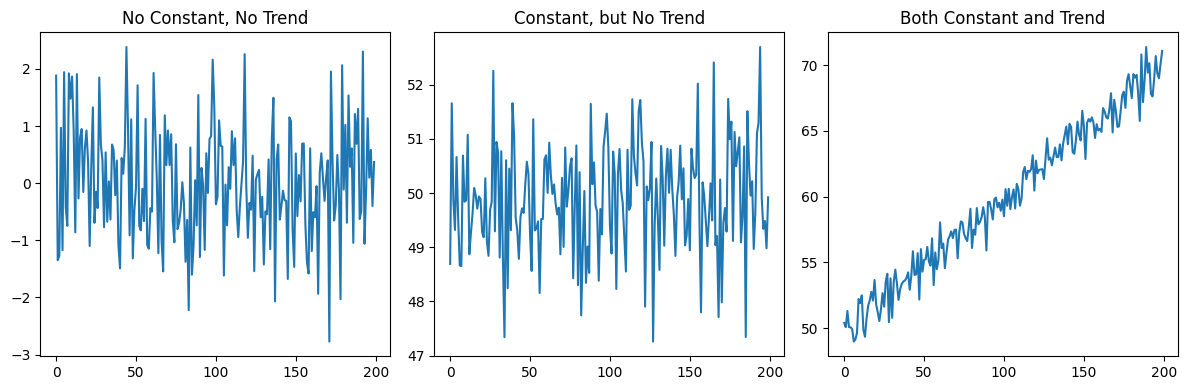

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
series_no_const_no_trend.plot(title='No Constant, No Trend')
plt.subplot(1, 3, 2)
series_const_no_trend.plot(title='Constant, but No Trend')
plt.subplot(1, 3, 3)
series_const_trend.plot(title='Both Constant and Trend')
plt.tight_layout();

In [6]:
# 1. No Constant or Trend
perform_adf_test(series_no_const_no_trend, "No Constant, No Trend", 'n')

# 2. Constant, but No Trend
perform_adf_test(series_const_no_trend, "Constant, No Trend", 'c')

# azot
# 2. Constant, but No Trend
perform_adf_test(series_const_no_trend, "Constant, No Trend", 'n')

# 3. Both Constant and Trend
perform_adf_test(series_const_trend, "Constant and Trend", 'ct')

# 3. Both Constant and Trend
perform_adf_test(series_const_trend, "Constant and Trend", 'n')


Results for No Constant, No Trend:
ADF Statistic: -15.47
p-value: 0.000
Used Lag: 0
Number of Observations: 199
Critical Values: ['1%: -2.58', '5%: -1.94', '10%: -1.62']

Results for Constant, No Trend:
ADF Statistic: -13.95
p-value: 0.000
Used Lag: 0
Number of Observations: 199
Critical Values: ['1%: -3.46', '5%: -2.88', '10%: -2.57']

Results for Constant, No Trend:
ADF Statistic: 0.16
p-value: 0.735
Used Lag: 12
Number of Observations: 187
Critical Values: ['1%: -2.58', '5%: -1.94', '10%: -1.62']

Results for Constant and Trend:
ADF Statistic: -14.68
p-value: 0.000
Used Lag: 0
Number of Observations: 199
Critical Values: ['1%: -4.00', '5%: -3.43', '10%: -3.14']

Results for Constant and Trend:
ADF Statistic: 7.10
p-value: 1.000
Used Lag: 8
Number of Observations: 191
Critical Values: ['1%: -2.58', '5%: -1.94', '10%: -1.62']



- В последних двух случаях, без учета ненулевого среднего значения и тренда, мы не отвергаем $H_0$.
- Попробуйте использовать ``'n'`` в последних двух примерах и убедитесь сами.

---

## Mean reversion test

- Возврат к среднему значению относится к свойству временного ряда возвращаться к своему историческому среднему значению.
- Эта концепция особенно популярна в финансовой экономике, где часто предполагается, что цены активов и возвращаются к своему историческому среднему значению в долгосрочной перспективе.
- Не существует надлежащего математического определения возврата к среднему значению.

### Применение в финансах

1. **Управление портфелем**
- Инвесторы используют возврат к среднему значению как стратегию покупки активов, которые показали низкую доходность, и продажи активов, которые показали высокую доходность, ожидая, что они вернутся к своему историческому среднему значению.

2. **Управление рисками**
    - Понимание возврата к среднему значению помогает оценить долгосрочный риск активов.
    - Если актив имеет высокую степень возврата к среднему значению, его можно считать менее рискованным в долгосрочной перспективе, поскольку он имеет тенденцию возвращаться к своему среднему значению.

3. **Модели ценообразования**
    - При ценообразовании опционов некоторые модели предполагают возврат к среднему значению волатильности базового актива.
    - Это влияет на ценообразование и стратегию торговли опционами.

4. **Экономическое прогнозирование**
    - Экономические переменные (такие как темпы роста ВВП, процентные ставки) часто демонстрируют возврат к среднему значению.
    - Это предположение используется в макроэкономических моделях и прогнозах.

### Тестирование на возврат к среднему значению
- Определяет, вернется ли временной ряд к этому среднему значению после отклонения от среднего значения.
- Это можно сделать с помощью тестов на единичный корень, таких как ADF.
- Если временной ряд имеет единичный корень, это означает, что он не возвращается к среднему значению.
- Отсутствие единичного корня может указывать на возврат к среднему значению.

**Пример: акции Google**

Мы загрузим данные Google Open-High-Low-Close-Volume (GOOG OHLCV) с 1 сентября 2004 г. по 31 августа 2020 г. из [Yahoo finance](https://finance.yahoo.com/) с помощью пакета Python ``yfinance``.

In [7]:
def get_data(tickerSymbol, interval, start, end):

    # Get data on the ticker
    tickerData = yf.Ticker(tickerSymbol)

    # Get the historical prices for this ticker
    tickerDf = tickerData.history(interval=interval, start=start, end=end)

    return tickerDf

data = get_data('GOOG', interval='1d', start='2004-09-01', end='2020-08-31')

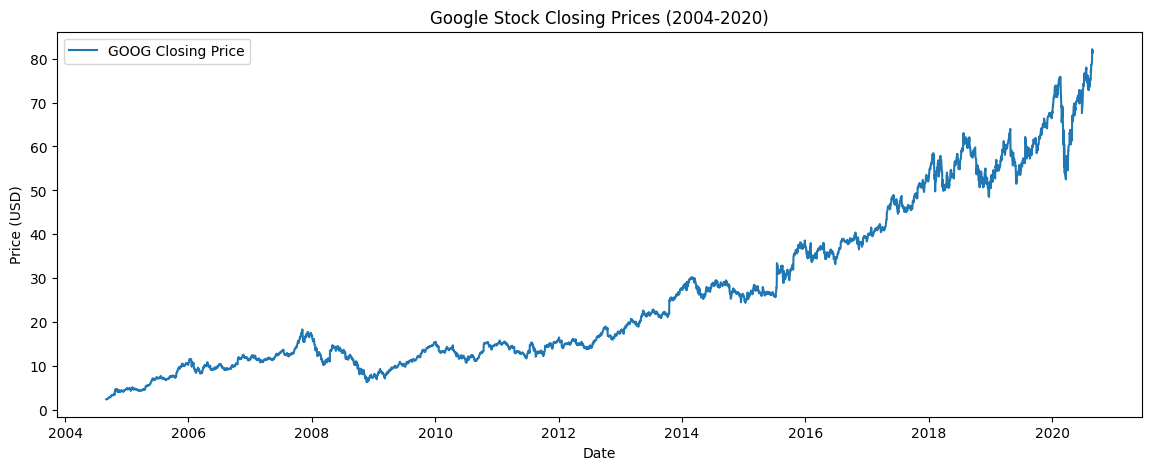

In [8]:
# Plotting the Closing Prices
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='GOOG Closing Price')
plt.title('Google Stock Closing Prices (2004-2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

In [9]:
# Perform the ADF test
perform_adf_test(data['Close'],"Google Stock Closing Prices", 'ct')

Results for Google Stock Closing Prices:
ADF Statistic: -0.78
p-value: 0.968
Used Lag: 26
Number of Observations: 4000
Critical Values: ['1%: -3.96', '5%: -3.41', '10%: -3.13']



- Мы не можем отклонить гипотезу $H_0$.
- Этот ряд не похож на временной ряд, возвращающийся в среднему значению.

### Возврат к среднему значению VS стационарность

Проверка возврата к среднему значению и проверка стационарности — это связанные, но разные концепции в анализе временных рядов.

**Ключевые различия**:
- Проверка возврата к среднему значению фокусируется на том, вернется ли временной ряд к определенному уровню (среднему значению).
- Проверка стационарности проверяет, остаются ли общие статистические свойства ряда неизменными с течением времени.
- Стационарный временной ряд может быть или не быть возвращающимся к среднему значению.
- Стационарный ряд с постоянным средним значением и дисперсией с течением времени может все еще не вернуться к своему среднему значению после шока.
- И наоборот, ряд с возвратом к среднему значению должен иметь некоторую стационарность, особенно в своем среднем значении, но он все еще может иметь изменяющуюся дисперсию или другие свойства с течением времени.

## Экспонента Херста, Показатель Херста

- Показатель Херста ($H$) - это мера, используемая для характеристики долговременной памяти временных рядов.
- Он помогает определить наличие автокорреляции или постоянства в данных.
- Цель показателя Херста - предоставить нам скалярное значение, которое поможет нам определить, является ли ряд
    - случайным блужданием,
    - трендовым,
    - возвратом к среднему.

- Ключевое понимание заключается в том, что если существует какая-либо *автокорреляция*, то

$$\text{Var}(X(t + \tau) - X(t)) \propto \tau^{2H}$$

- где $H$ - показатель Херста.

Временной ряд можно охарактеризовать следующим образом:

- Если $H = 0,5$, временной ряд похож на случайное блуждание. В этом случае дисперсия увеличивается линейно с $\tau$.
- Если $H < 0,5$, временной ряд демонстрирует антиперсистентность, т. е. возврат к среднему. Дисперсия увеличивается медленнее, чем линейно с $\tau$.
- Если $H > 0,5$, временной ряд демонстрирует устойчивую долгосрочную зависимость, т. е. является трендовым. Дисперсия увеличивается быстрее, чем линейно с $\tau$.

In [10]:
def hurst(ts):

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.var(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]/2.0

**Как выглядят постоянные и антипостоянные временные ряды?**

- Давайте создадим скрипт Python (адаптированный отсюда](https://github.com/Mottl/hurst/tree/master)) для генерации случайного блуждания с сохранением.
- Мы должны включить форму «памяти», рассматривая прошлые значения в указанном окне просмотра, чтобы определить направление следующего шага.

Давайте определим

```python
def random_walk_memory(length, proba, min_lookback, max_lookback)
```

где:
- ``proba`` - вероятность того, что следующий шаг будет следовать тренду.
    - proba > 0,5 постоянный случайный блуждание
    - proba < 0,5 антиперсистентный

- ``min_lookback`` и ``max_lookback`` - минимальный и максимальный размеры окна для расчета направления тренда

In [11]:
def random_walk_memory(length, proba=0.5, min_lookback=1, max_lookback=100):
    series = [0.] * length
    for i in range(1, length):

        # If the series has not yet reached the min_lookback threshold
        # the direction of the step is random (-1 or 1)
        if i < min_lookback + 1:
            direction = np.sign(np.random.randn())

        # consider the historical values to determine the direction
        else:
            # randomly choose between min_lookback and the minimum of
            # i-1 (to ensure not exceeding the current length) and max_lookback.
            lookback = np.random.randint(min_lookback, min(i-1, max_lookback)+1)

            # Decides whether to follow the recent trend or move against it,
            # based on a comparison between proba and a random number between 0 and 1.
            recent_trend = np.sign(series[i-1] - series[i-1-lookback])
            change = np.sign(proba - np.random.uniform())
            direction = recent_trend * change

        series[i] = series[i-1] + np.fabs(np.random.randn()) * direction
    return series

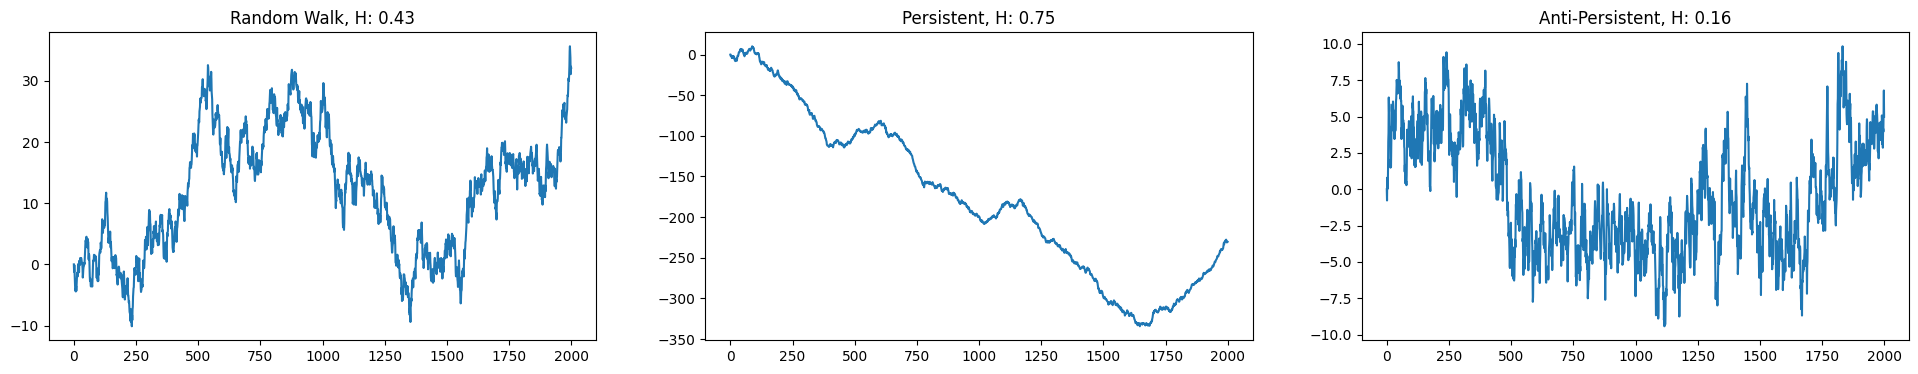

In [12]:
bm = random_walk_memory(2000, proba=0.5)
persistent = random_walk_memory(2000, proba=0.7)
antipersistent = random_walk_memory(2000, proba=0.3)

_, axes = plt.subplots(1,3, figsize=(24, 4))
axes[0].plot(bm)
axes[0].set_title(f"Random Walk, H: {hurst(bm):.2f}")
axes[1].plot(persistent)
axes[1].set_title(f"Persistent, H: {hurst(persistent):.2f}")
axes[2].plot(antipersistent)
axes[2].set_title(f"Anti-Persistent, H: {hurst(antipersistent):.2f}");

- Каков показатель Херста цены закрытия акций Google?

In [13]:
print(f"GOOG closing price, H: {hurst(data['Close'].values):.2f}")

GOOG closing price, H: 0.41


- Временной ряд акций Google приближается к $H=0,5$, что указывает на то, что он близок к геометрическому случайному блужданию (по крайней мере, для рассматриваемого нами периода выборки).
- Что это означает на практике?

### Интерпретация показателя Херста в финансах:

- Показатель Херста, $H$, является важнейшей метрикой в ​​анализе финансовых временных рядов.
- Дает представление о поведении активов, таких как акции.
- Вот как интерпретировать $H$ в контексте *заключительных цен акций* и его влияния на *инвестиционные решения*.

**Случай 1: $H = 0,5$**

- Это значение предполагает, что цена акций следует случайному блужданию.
- Это подразумевает, что будущие движения цен не зависят от прошлых движений.
- Для инвесторов это означает, что в движениях цен нет автокорреляций, которые можно было бы использовать; прошлые данные не могут предсказать будущие цены.
- Торговые стратегии, основанные на исторических ценовых моделях или тенденциях, теоретически не более успешны, чем случайные угадывания.
- Инвесторам следует полагаться на более широкий анализ рынка или стратегии диверсифицированного портфеля, а не пытаться предсказать будущие цены на основе прошлых тенденций.

**Случай 2: $H < 0,5$**

- Указывает на серию возврата к среднему значению, т. е. цена акций имеет тенденцию возвращаться к своему историческому среднему значению.
- Это говорит о том, что актив менее рискован в долгосрочной перспективе.
- Инвесторы могут интерпретировать низкий $H$ как возможность купить акции после значительного падения, ожидая возврата к среднему значению, или продать после существенного роста.

**Случай 3: $H > 0,5$**

- Предполагает трендовую серию, где рост или падение цен на акции, вероятно, будут сопровождаться дальнейшим ростом или падением соответственно.
- Эта устойчивость указывает на потенциальный импульс цен на акции, который можно использовать с помощью стратегий импульса:
- Покупка акций, которые растут, в надежде, что они продолжат расти, и продажа тех, которые растут в нисходящем тренде.

#### Практические соображения:

Прежде чем применять эти интерпретации, инвесторам следует также учесть следующие соображения:
- Наблюдаемое значение $H$ может меняться в разных временных рамках: проанализируйте $H$ за период, соответствующий инвестиционному горизонту.
- Внешние факторы, такие как рыночные условия, экономические показатели и геополитические события, могут влиять на цены акций и должны рассматриваться наряду с $H$.
- Независимо от значения $H$, реализация надлежащих стратегий управления рисками имеет важное значение для защиты от неожиданных движений рынка.
- Если временной ряд слишком короткий, значение $H$ может быть ненадежным.

---

## Броуновское движение

- Вспомним случайное блуждание

$$X(t) = X(t-1) + \epsilon_t$$

- где $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.

- Это также можно выразить как:

$$X(t) = X(0) + W(t)$$

- где $W(t)$ называется *Винеровским процессом*, или как:

$$X(t) = X(0) + B(t)$$

- где $B(t)$ называется *Броуновским движением*.
- $W(t)$ и $B(t)$ представляют собой кумулятивную сумму нормально распределенных приращений $\epsilon_1 + \epsilon_2 + \dots \epsilon_t$.

**Дисперсия броуновского движения при задержке $\tau$**

- Для временного ряда $X(t)$ дисперсия при задержке $\tau$ может быть определена как:

$$\text{Var}(X(t + \tau) - X(t))$$

- Если $B(t)$ рассматривается как броуновское движение, то приращение $B(t + \tau) - B(t)$ нормально распределено со средним значением 0 и дисперсией $\tau$.
- Это происходит потому, что дисперсия приращений броуновского движения за период $\tau$ равна $\tau$.

$$\text{Var}(B(t + \tau) - B(t)) = \tau$$

---

## Геометрическое броуновское движение

- *Геометрическое броуновское движение* (GBM) — это стохастический процесс.
- Его часто используют для моделирования цен акций и других финансовых переменных, которые не возвращаются к среднему значению, а скорее демонстрируют тенденции с дрейфом $\mu$ и волатильностью $\sigma$.

GBM определяется как:

$$S(t) = S_0 \exp\left((\mu - \frac{1}{2} \sigma^2)t + \sigma W(t)\right)$$

- где
    - $S(t)$ - цена акций в момент времени $t$.
    - $S_0$ - начальная цена акций в момент времени $t = 0$.
    - $\mu$ - ожидаемая годовая доходность (коэффициент дрейфа).
    - $\sigma$ - волатильность (стандартное отклонение доходности).
    - $W(t)$ - винеровский процесс (стандартное броуновское движение).

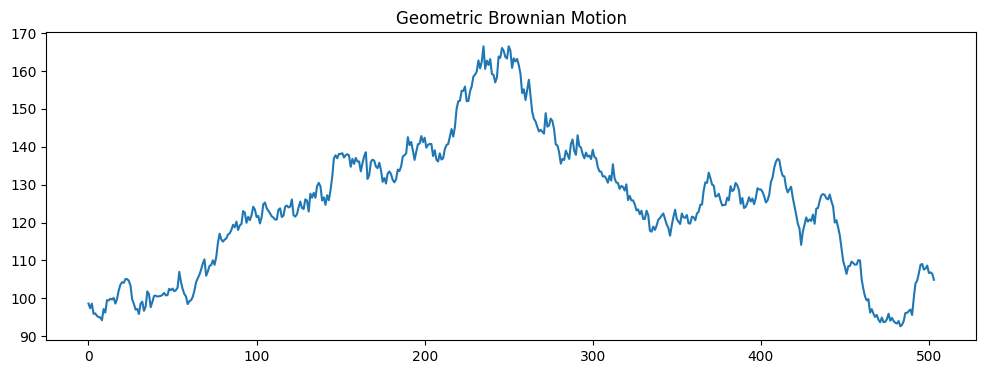

In [14]:
S0 = 100                 # Initial stock price
mu = 0.09                # Expected annual return (9%)
sigma = 0.25             # Annual volatility (25%)
T = 2                    # Time horizon in years
dt = 1/252               # Time step in years, assuming 252 trading days per year
N = int(T/dt)            # Number of time steps
t = np.linspace(0, T, N) # Time vector

# Brownian Motion
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)

# Geometric Brownian Motion
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(12, 4))
plt.plot(S)
plt.title('Geometric Brownian Motion');

### Дисперсия GBM

- Во-первых, обратите внимание, что $S(t)$ распределен *логарифмически нормально*, поскольку является экспоненциальной функцией нормально распределенного процесса $B(t)$.
- Дисперсию $S(t)$ можно найти из свойств логарифмически нормального распределения:

$$\text{Var}(S(t)) = \left(e^{\sigma^2 t} - 1\right) e^{2\mu t + \sigma^2 t} S_0^2.$$

- Это показывает, что дисперсия GBM не линейна по $t$, как у BM.
- Вместо этого она растет *экспоненциально* со временем из-за экспоненциального члена $e^{\sigma^2 t}$.
- Это, а также возможность дрейфа моделирования (ожидаемая годовая доходность) являются основными дополнениями GBM по сравнению с BM.

### Реальные приложения

- GBM можно использовать для моделирования реальных цен акций и имитации их будущего поведения.
- Сначала мы оцениваем $\mu$ и $\sigma$ на основе исторических данных о ценах акций.
    - $\mu$ может быть историческим средним значением логарифмической доходности акций.
    - $\sigma$ может быть стандартным отклонением этой доходности.
    - Затем мы используем эти оценки в формуле GBM для имитации будущих ценовых траекторий.

- Этот метод широко используется для ценообразования опционов, управления рисками и моделирования инвестиционных стратегий.
- Однако GBM имеет ограничения, такие как предположение о *постоянном дрейфе и волатильности*.
- Эти предположения могут не соответствовать действительности на реальных рынках.
- Поэтому его часто используют как компонент более широкого анализа или стратегии моделирования.

In [15]:
# Step 1: Get the "training" data (e.g., 2020-2022)
data2 = get_data('GOOG', interval='1d', start='2019-12-31', end='2022-12-31')


In [16]:
# Get "test" data, for comparison (e.g., 2023)
data3 = get_data('GOOG', interval='1d', start='2022-12-31', end='2023-12-31')
test_days = len(data3)

In [17]:
# Step 2: Calculate Daily Returns
# We are interested in the returns, so we get the changes in %
returns = data2['Close'].pct_change() 

In [18]:
# Step 3: Estimate Parameters for GBM
mu = returns.mean() * 252  # Annualize the mean
sigma = returns.std() * np.sqrt(252)  # Annualize the std deviation

In [19]:
# Step 4: Set GBM parameters
T = 1  # Time horizon in years
dt = 1/test_days  # Time step in years, assuming 252 trading days per year
N = int(T/dt)  # Number of time steps
time_step = np.linspace(0, T, N)
S0 = data2['Close'].iloc[-1]  # Starting stock price (latest close price)

In [20]:
#  Step 5: Compute Simulation
W = np.random.standard_normal(size=N)
W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum for the Wiener process
X = (mu - 0.5 * sigma**2) * time_step + sigma * W
S = S0 * np.exp(X)  # GBM formula

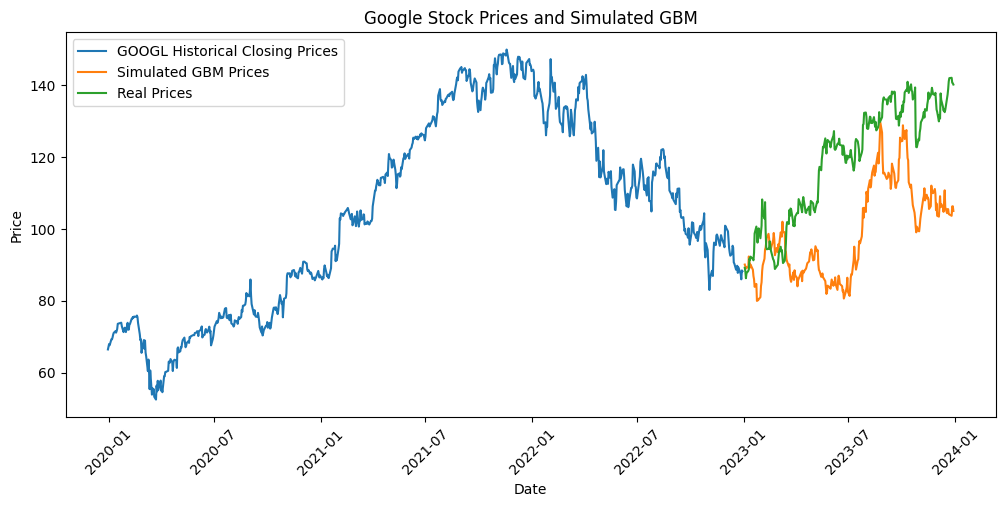

In [21]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, S, label='Simulated GBM Prices')
plt.plot(data3['Close'], label='Real Prices')
plt.legend()
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

- В каждой реализации GBM присутствует стохастический компонент.
- Обычно моделируется больше путей, чтобы получить более информативную симуляцию.

In [22]:
# Simulate multiple paths
n_paths = 10
paths = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * time_step + sigma * W
    paths.append(S0 * np.exp(X))

path_mean = np.array(paths).mean(axis=0)
path_std = np.array(paths).std(axis=0)

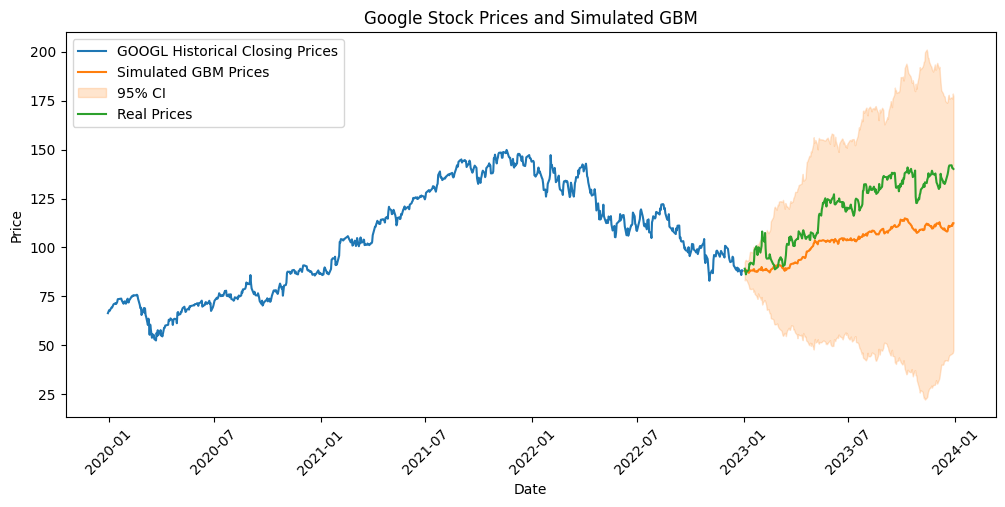

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, path_mean, label='Simulated GBM Prices')
plt.fill_between(data3.index, path_mean-1.96*path_std, path_mean+1.96*path_std, color='tab:orange', alpha=0.2, label='95% CI')
plt.plot(data3['Close'], label='Real Prices')
plt.legend(loc='upper left')
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

---

## Резюме

В этой лекции мы рассмотрели:
1. Тест на единичный корень и более глубокое понимание теста ADF.
2. Возврат к среднему и как его проверить с помощью ADF.
3. Показатель Херста: как его вычислить и его применение в финансах.
4. Геометрическое броуновское движение: определение и применение для моделирования акций.

## Упражнение

- Загрузите и нанесите на график исторические цены закрытия Tesla (``TSLA``) и Equinor (``EQNR``) за годы ``2019-12-31``- ``2022-12-31``.
- Для каждого временного ряда:
    - Проверьте, выглядит ли временной ряд стационарным.
    - Вычислите коэффициент Херста для обоих временных рядов.
    - В какие акции вы хотели бы инвестировать? Обоснуйте свой ответ на основе тестов и значения $H$.
    - Смоделируйте цены акций с помощью GBM.

- Какая симуляция кажется более надежной? Для Tesla или Equinor?
- Чтобы обосновать свой ответ:
1. вычислите симуляцию не менее 100 раз.
2. Вычислите MSE между истинными ценами акций и смоделированными.
3. Сравните ожидаемое значение MAPE для двух акций.

- Загрузите и нанесите на график исторические цены закрытия Tesla (``TSLA``) и Equinor (``EQNR``) за годы ``2019-12-31``- ``2022-12-31``.

In [24]:
tsla_data = get_data('TSLA', interval='1d', start='2019-12-31', end='2022-12-31')
# Equinor is a Norway-based integrated oil and gas company
eqnr_data = get_data('EQNR', interval='1d', start='2019-12-31', end='2022-12-31')

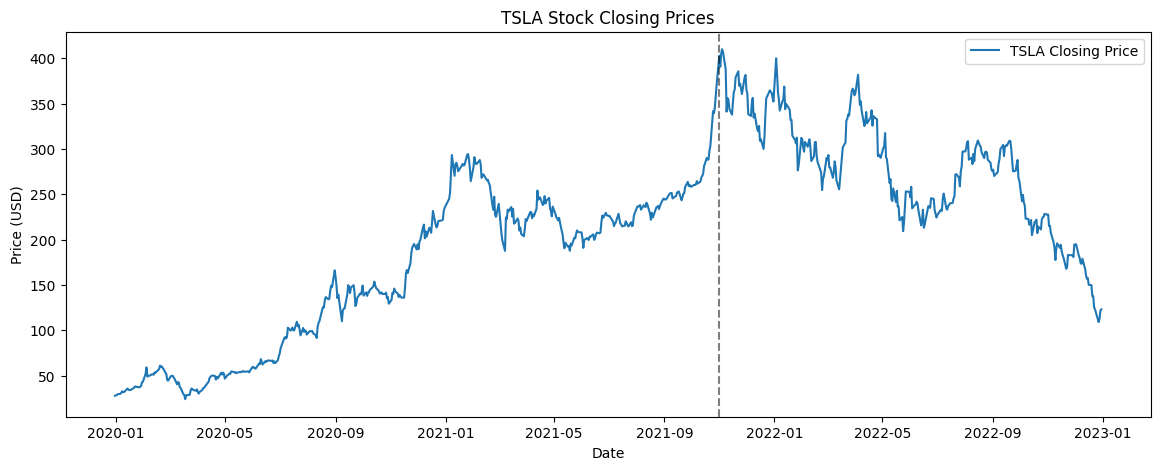

In [25]:
plt.figure(figsize=(14, 5))
plt.plot(tsla_data['Close'], label='TSLA Closing Price')
plt.axvline(pd.to_datetime('2021-11-01'), color='black', alpha=0.5, linestyle='--')
plt.title('TSLA Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

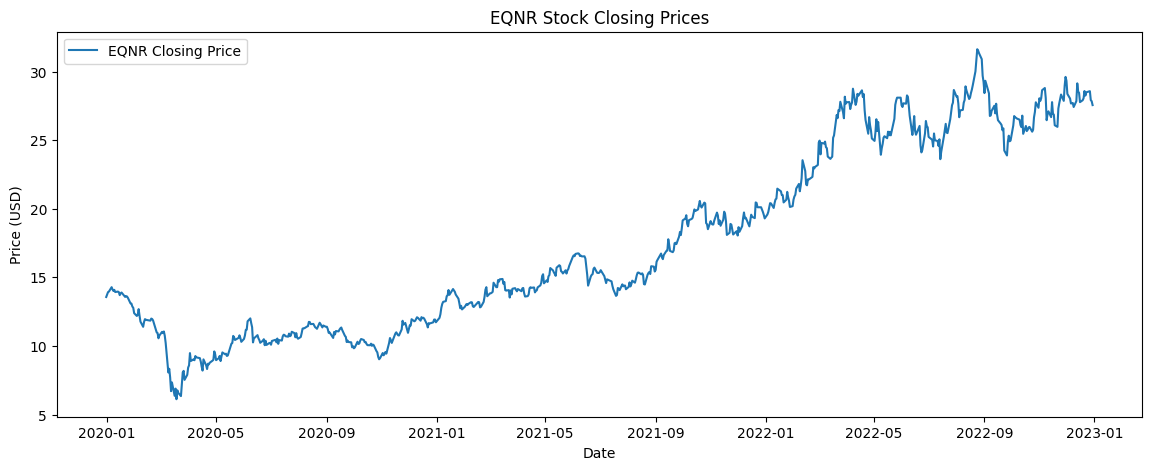

In [26]:
plt.figure(figsize=(14, 5))
plt.plot(eqnr_data['Close'], label='EQNR Closing Price')
plt.title('EQNR Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

- Проверьте, выглядит ли временной ряд стационарным.

adf тест для TSLA  
по умолчанию уровень достоверности $\alpha$ = 0.05 (5%)  
статистика теста -1.86 - это коэффициент $\gamma$ (пропорциональность занчению ряда с лагом 1)  
used_lag:9 - adf модель (уравнение теста) имела 9 лагов  
critical values - критические значения из распределения Дикки-Фуллера (табличные значения для конкретной моддели теста)  
p-value - стат значимость нулевой гипотезы

если статистика меньше критического значения, $H0$ отвергается

In [27]:
# TSLA - ряд нестационарный
perform_adf_test(tsla_data['Close'],title='TSLA ADF test',regression_type='c')

Results for TSLA ADF test:
ADF Statistic: -1.86
p-value: 0.349
Used Lag: 9
Number of Observations: 747
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



In [28]:
# визуально на графике визуально есть слом тренда 
# можно попробовать посмотреть стационарность на интервале
# результат - ряд нестационарный на обоих интервалах
perform_adf_test(tsla_data.loc[:'2021-11-01']['Close'],
                 title='TSLA[:2021-11-01] ADF test',
                 regression_type='ct')
perform_adf_test(tsla_data.loc['2021-11-02':]['Close'],
                 title='TSLA[2021-11-02:] ADF test',
                 regression_type='ct')

Results for TSLA[:2021-11-01] ADF test:
ADF Statistic: -0.98
p-value: 0.947
Used Lag: 0
Number of Observations: 463
Critical Values: ['1%: -3.98', '5%: -3.42', '10%: -3.13']

Results for TSLA[2021-11-02:] ADF test:
ADF Statistic: -2.39
p-value: 0.387
Used Lag: 9
Number of Observations: 283
Critical Values: ['1%: -3.99', '5%: -3.43', '10%: -3.14']



In [29]:
# ряд имеет тренд, но без тренда можно считать стационарным (-3.60 < -3.42)
# хороший пример -  alpha=0.05; p-value > 0.05, но формально H0 мы должны отклонить 
# ?? used_lag 0 - почему-то критерий AIC решил не использовать сумму дельт
perform_adf_test(eqnr_data['Close'],title='EQNR ADF test',regression_type='ct')

Results for EQNR ADF test:
ADF Statistic: -3.60
p-value: 0.030
Used Lag: 0
Number of Observations: 756
Critical Values: ['1%: -3.97', '5%: -3.42', '10%: -3.13']



- Вычислите коэффициент Херста для обоих временных рядов.

In [30]:
# экспонента херста - это как дисперсия растёт от лага 
# (степенная от лага и в показателе 2H)

# TSLA - ряд близок к случайному блужданию
print(f'tsla hurst: {hurst(tsla_data['Close'].values):.2f}')

tsla hurst: 0.46


In [31]:
# а что на интервалах?
# вторую половину ряда можно характеризовать как антиперсистентную
print(f'tsla[:2021-11-01] hurst: {hurst(tsla_data.loc[:'2021-11-01']['Close'].values):.2f}; nobs: {len(tsla_data.loc[:'2021-11-01'])}')
print(f'tsla[2021-11-02:] hurst: {hurst(tsla_data.loc['2021-11-02':]['Close'].values):.2f}; nobs: {len(tsla_data.loc['2021-11-02':])}')

tsla[:2021-11-01] hurst: 0.46; nobs: 464
tsla[2021-11-02:] hurst: 0.27; nobs: 293


In [32]:
# ENQR - ряд похож на антиперсистентый
print(f'eqnr hurst: {hurst(eqnr_data['Close'].values):.2f}')

eqnr hurst: 0.33


- В какие акции вы хотели бы инвестировать? Обоснуйте свой ответ на основе тестов и значения $H$.

TSLA в последнее время показывает признаки ряда с тенденцией возврата к среднему. Акции находятся ниже средней цены. Я бы покупал акции

EQNR показывает признаки ряда с тенденцией возврата к среднему. Акции находятся выше средней цены за сто дней. И вроде как нужно продавать. Но проблема определить среднее. Если  взять среднее за 200 дней, то среднее будет чуть выше. И тогда сигнал продавать не такой очевидный. Я бы предпочёл не иметь дела с ENQR в данный момент

- Смоделируйте цены акций с помощью GBM.

In [33]:
def gbm_sim(
        data : pd.Series,
        #sim_start : pd.Timestamp,
        #sim_end : pd.Timestamp,
        N : int,
        sim_cnt : int
        ) :
    '''
    tr - даные для тренировки
    sim_start, sim_end - интервал дат, на котором строим симуляцию
    N - кол-во шагов по времени в симуляции
    sim_cnt - количество симуляций
    '''

    # Step 2: Calculate Daily Returns
    # We are interested in the returns, so we get the changes in %
    #Fractional change between the current and a prior element
    returns = data.iloc[:-N].pct_change()

    # Step 3: Estimate Parameters for GBM
    mu = returns.mean() * 252  # Annualize the mean
    sigma = returns.std() * np.sqrt(252)  # Annualize the std deviation

    # Step 4: Set GBM parameters
    dt = 1 / 252 # Time step in years, assuming 252 trading days per year
    T = N * dt  # Time horizon in years
    time_step = np.linspace(dt, T, N)
    S0 = data.iloc[-N-1]  # Starting stock price (latest close price)

    #  Step 5: Compute Simulation
    sims=pd.DataFrame([],index=data.index[-N:])
    for i in range(sim_cnt):
        W = np.random.standard_normal(size=N)
        W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum for the Wiener process
        X = (mu - 0.5 * sigma**2) * time_step + sigma * W
        sims[f'sim{i}'] = S0 * np.exp(X)  # GBM formula

    return sims

In [34]:
# тест симуляции - две симуляции
print(tsla_data.index[-121],tsla_data['Close'].iloc[-121])
gbm_sim(tsla_data['Close'], N=120, sim_cnt=2)

2022-07-12 00:00:00-04:00 233.07000732421875


,sim0,sim1
Date,,
2022-07-13 00:00:00-04:00,236.465278,237.587324
2022-07-14 00:00:00-04:00,222.499957,232.876934
2022-07-15 00:00:00-04:00,245.572032,218.759263
2022-07-18 00:00:00-04:00,258.187714,227.685508
2022-07-19 00:00:00-04:00,282.185780,219.704528
...,...,...
2022-12-23 00:00:00-05:00,573.501710,401.872668
2022-12-27 00:00:00-05:00,559.106708,443.609414
2022-12-28 00:00:00-05:00,546.436344,461.360007


In [35]:
# график симуляции
def sims_show(data,N,sims,tick):

    sims_mean = sims.mean(axis=1)
    sims_std = sims.std(axis=1)
    mean_mse = mean_squared_error(data[-N:],sims_mean)
    mean_rmse = root_mean_squared_error(data[-N:],sims_mean)
    mean_mape = mean_absolute_percentage_error(data[-N:],sims_mean)

    title=f'{tick} Stock Prices and Simulated GBM'
    title+=f' (MSE:{mean_mse:.2f}; RMSE:{mean_rmse:.2f}; MAPE:{mean_mape:.2f})'
    
    plt.figure(figsize=(12, 5))
    plt.plot(data[:-N-1], label=f'{tick} Historical Prices')
    plt.plot(data[-N:], label='Real Prices')
    plt.plot(sims.iloc[:,0], label='Simulation[0] GBM Prices')
    plt.plot(sims_mean, label='Simulated GBM mean Prices')
    plt.fill_between(sims.index,sims_mean-1.96*sims_std, sims_mean+1.96*sims_std, color='tab:orange', alpha=0.2, label='96% CI')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.title(title)

    plt.show()

**TSLA**

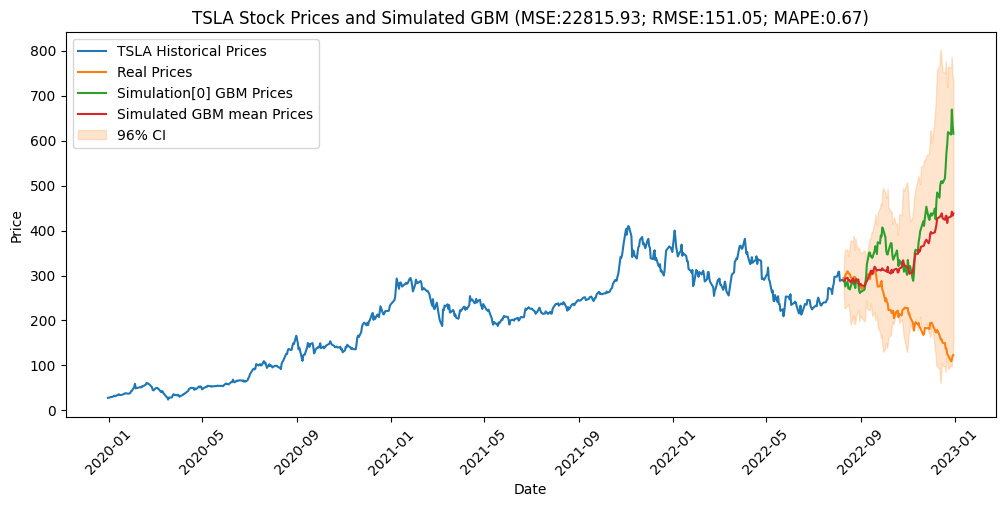

In [36]:
N0=100
sim_cnt0=5
tsla_sims = gbm_sim(tsla_data['Close'], N=N0, sim_cnt=sim_cnt0)
sims_show(tsla_data['Close'],N0,tsla_sims,'TSLA')

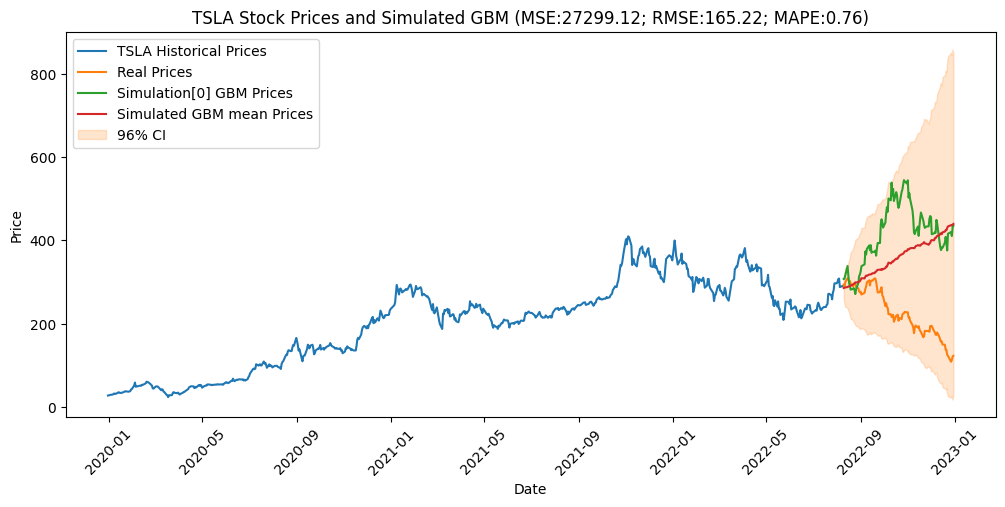

In [37]:
# чем больше симуляций, тем более гладкое среднее
N=100
sim_cnt=100
tsla_sims = gbm_sim(tsla_data['Close'], N=N, sim_cnt=sim_cnt)
sims_show(tsla_data['Close'],N,tsla_sims,'TSLA')

**EQNR**

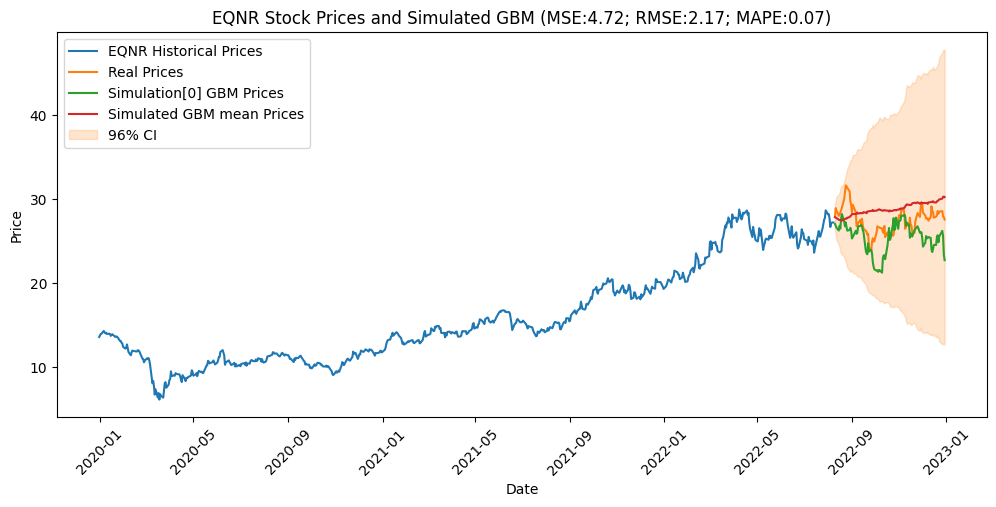

In [39]:
eqnr_sims = gbm_sim(eqnr_data['Close'], N=N, sim_cnt=sim_cnt)
sims_show(eqnr_data['Close'],N,eqnr_sims,'EQNR')

- Какая симуляция кажется более надежной? Для Tesla или Equinor?

Как ни странно, при таком широком разбросе симуляций модель среднего по симуляциям даёт лучший результат для EQNR (EQNR MAPE=0.12; TSLA MAPE=0.76)

- Чтобы обосновать свой ответ:
1. вычислите симуляцию не менее 100 раз.
2. Вычислите MSE между истинными ценами акций и смоделированными.

TSLA MSE=27299.12; EQNR MSE=4.72

3. Сравните ожидаемое значение MAPE для двух акций.

TSLA MAPE=0.76; EQNR MAPE=0.12